In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# 1. 读数据及数据初步探索

In [42]:
import os


In [43]:
train= pd.read_csv('nlp/train.csv')

In [44]:
test= pd.read_csv('nlp/test.csv')

In [45]:
train.head(3)
'''用pandas中的head函数验证读取数据是否准确'''

'用pandas中的head函数验证读取数据是否准确'

In [46]:
print('There are {0} rows and {1} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {0} rows and {1} columns in test'.format(test.shape[0],test.shape[1]))
'''利用print中的format来控制print格式，{0}， {1}表示通过位置，将train.shape[0],train.shape[1]传递给{0},{1}'''

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


'利用print中的format来控制print格式，{0}， {1}表示通过位置，将train.shape[0],train.shape[1]传递给{0},{1}'

我们所拿到数据的target只有0和1，先通过初步的数据可视化分别了解在训练集中数据target的分布情况

Text(0, 0.5, 'samples')

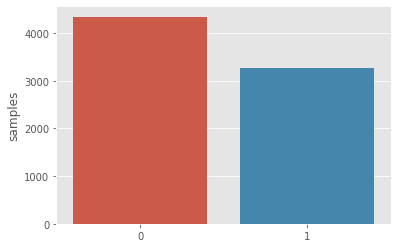

In [47]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

我们可以看到，在训练集中，target为0，即不是disaster的sample要明显多于是disaster的sample

# 2. 训练集数据分析

## 2.1 tweet字符数与是否为disaster的相关性

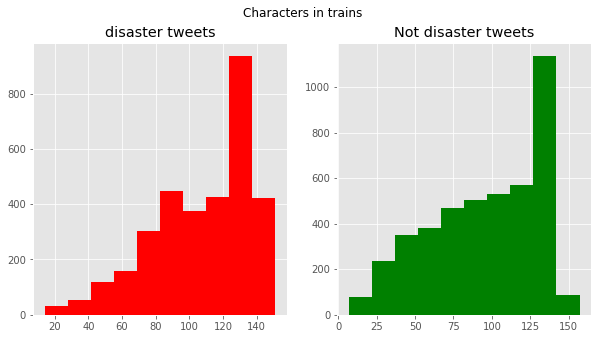

In [48]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in trains')
plt.show()

我们可以看出，disaster tweets与非disaster tweets的字符数分布是差不多的

## 2.2 tweet单词数与是否为disaster的相关性


### 2.2.1 每条tweet中的单词数

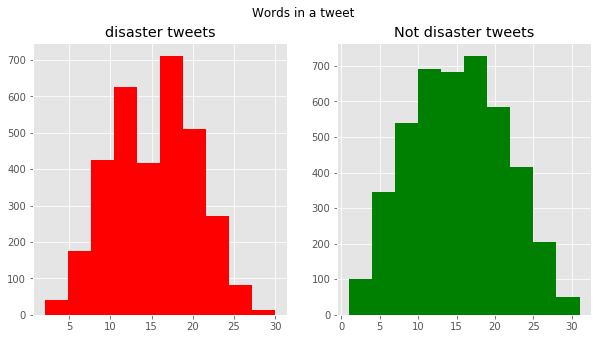

In [49]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### 2.2.2 每条tweet的平均词长

Text(0.5, 0.98, 'Average word length in each tweet')

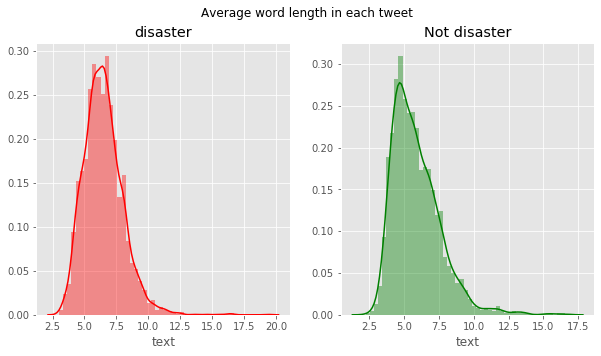

In [50]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [51]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### 2.2.3 tweet中的常见停用词

首先分析在训练集中 target为0的tweets

In [52]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

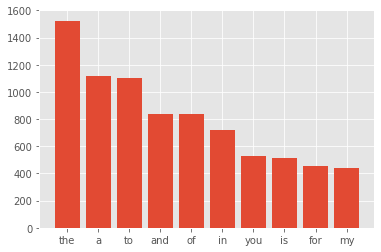

In [53]:
x,y=zip(*top)
plt.bar(x,y)

分析在训练集中target为1的tweets

<BarContainer object of 10 artists>

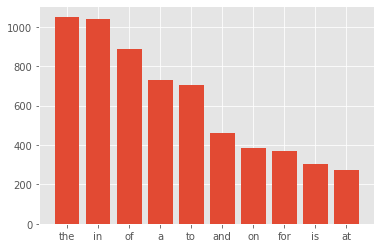

In [54]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

### 2.2.4 tweet中的标点符号


对 target为1的tweet进行分析

<BarContainer object of 18 artists>

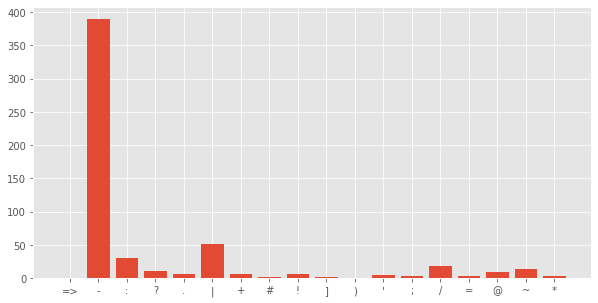

In [55]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

对 target为0的tweet进行分析

<BarContainer object of 20 artists>

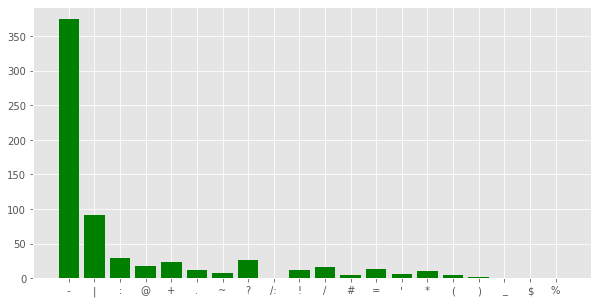

In [56]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

常用词

In [57]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

在这里用到了python原生的counter函数，counter函数的作用就是在一个数组内，遍历所有元素，将元素出现的次数记下来；
在此处我们将每个word出现的次数记录下来， 并将前40个最高频的非停用词word输出

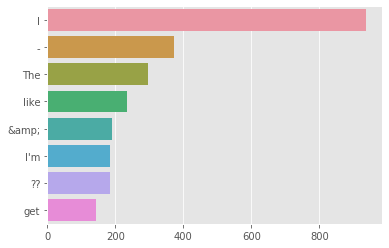

In [58]:
sns.barplot(x=y,y=x)

可以看到有很多无意义的词，所以需要做大量的数据清洗工作

# 3. N-gram 分析

## 3.1 前置知识

N-Gram（有时也称为N元模型）是自然语言处理中一个非常重要的概念，通常在NLP中，人们基于一定的语料库，可以利用N-Gram来预计或者评估一个句子是否合理。另外一方面，N-Gram的另外一个作用是用来评估两个字符串之间的差异程度。这是模糊匹配中常用的一种手段。

## 3.2 Bigram分析

Bigram: 二元分词，将句子从头到尾每两个字组成一个词语

In [59]:
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

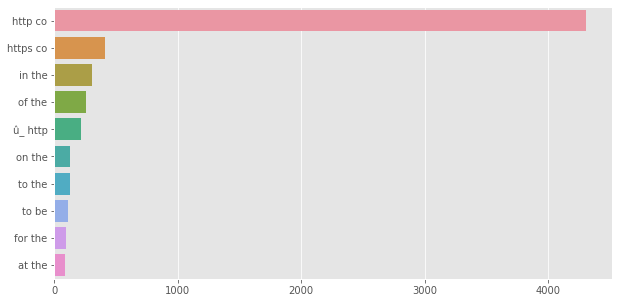

In [60]:
plt.figure(figsize=(10,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

我们可以看到出现了许多如http co, https co等无关的词语，这些都需要做数据清洗

# 4. 数据清洗

人们在twitter上发表tweet的时候会使用大量诸如标点符号，表情等对于我们建模有所干扰的元素，且有些tweet甚至会出现一些拼写上的错误，所以我们在建模之前首先要针对这些方面做数据清洗。

In [61]:
df=pd.concat([train,test])
df.shape

/Users/4paradigm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

这里用到pandas中的concat对训练集，测试集的数据合并

## 4.1 清理URL项

In [62]:
example="breaking news :https://www.cnn.com/ncov2019"


In [63]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'breaking news :'

In [64]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

## 4.2 清理 HTML tags

In [65]:
example = """<div>
<h1>nCov2019</h1>
<p>Wuhan </p>
<a href="https://www.cnn.com/ncov2019">breaking</a>
</div>"""

In [66]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


nCov2019
Wuhan 
breaking



In [67]:
df['text']=df['text'].apply(lambda x : remove_html(x))

## 4.3 清理Emojis

In [68]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [69]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

## 4.4 清理标点符号

In [70]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="i am not suffering from #ncov2019"
print(remove_punct(example))

i am not suffering from ncov2019


In [71]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

## 4.5 拼写纠错

在这里调用pyspellchecker包来做拼写纠错

In [72]:
!pip install pyspellchecker

In [88]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "thnak you"
correct_spellings(text)

'thank you'

In [89]:
import nltk

## 4.6 使用GloVe首先向量化

这里我们使用GloVe预训练的语料库来表示我们的词。一共有50维、100维、200维供我们选择，在这里我们选择100维

In [96]:
def create_corpus(df):
    corpus=[]
    for train in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(train) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        

In [98]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7708.88it/s]


In [103]:
embedding_dict={}
with open('Basic EDA and Baseline model/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [111]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [112]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [113]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 418180.50it/s]


# 5. 模型基线

In [114]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [124]:
train=train_pad[:train.shape[0]]
test=train_pad[train.shape[0]:]
print(train)
print(test)

[[ 622 5467  738 ...    0    0    0]
 [  96    7  138 ...    0    0    0]
 [ 119 1469 1386 ...    0    0    0]
 ...
 [ 396  462 1459 ...    0    0    0]
 [  23 1128 3820 ...    0    0    0]
 [   2  147   82 ...    0    0    0]]
[[ 134  701 1393 ...    0    0    0]
 [ 294  175 1222 ...    0    0    0]
 [  96    7  728 ...    0    0    0]
 ...
 [ 749  478  348 ...    0    0    0]
 [4085  536  372 ...    0    0    0]
 [3997 2557 1462 ...    0    0    0]]


In [125]:
X_train,X_test,y_train,y_test=train_test_split(train,train['target'].values,test_size=0.15)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices